In [2]:
import os
import random
import warnings
from functools import reduce
from datetime import datetime
from pathlib import Path
from typing import Union

import gdown
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from sklearn.preprocessing import MinMaxScaler
import numpy as np
np.random.seed(1776)

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_ms_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps_v2,
                                generate_enriched_gp_info_plots)

from utilities import spatial_subset


/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [3]:
notebook_name = "0-b2c_load_raw_data.ipynb" 
notebook_path = Path.cwd() / notebook_name
load_timestamp = "2024-11-26_08-36-17"
current_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")


data_folder_path = Path.cwd().parent / ".data"
nichecompass_data_path = data_folder_path / "nichecompass" 

In [30]:
adata = sc.read_h5ad(data_folder_path / "processed" / "preprocessing" / "2024-11-22_16-58-56_VisiumHD_mouse_lung_bin2cell.h5ad")

In [16]:
# Load trained model
model = NicheCompass.load(
    dir_path=nichecompass_data_path / "artifacts" / "2-NicheCompass.ipynb" / load_timestamp   / "model",
    adata=None,
    adata_file_name="adata.h5ad",
    gp_names_key="nichecompass_gp_names"
)

/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/anndata/__init__.py:55: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1000, n_cat_covariates_embed_input: 0, n_hidden: 256, n_latent: 156, n_addon_latent: 100, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 156, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 1000
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 156, n_addon_gp_input: 100, n_cat_covariates_embed_input: 0, n_output: 1000


/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/nichecompass/models/utils.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dic

In [24]:
model.adata

AnnData object with n_obs × n_vars = 313497 × 1000
    obs: 'bin_count', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'nichecompass_active_gp_names', 'nichecompass_genes_idx', 'nichecompass_gp_names', 'nichecompass_latent', 'nichecompass_source_genes_idx', 'nichecompass_sources_categories_label_encoder', 'nichecompass_target_genes_idx', 'nichecompass_targets_categories_label_encoder', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_umap', 'nichecompass_latent', 'spatial', 'spatial_cropped'
    varm: 'nichecompass_gp_sources', 'nichecompass_gp_sources_categories', 'nichecompass_gp_targets', 'nichecompass_gp_targets_categories'
    obsp: 'nichecompass_latent_connectivities', 'nichecompass_latent_distances', 'spatial_connectivities', 'spatial_distances'

In [25]:
# Compute latent Leiden clustering
sc.tl.leiden(
    adata=model.adata,
    resolution=0.4,
    key_added="latent_leiden_0.4",
    neighbors_key="nichecompass_latent"
)

In [26]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key="latent_leiden_0.4"
)

In [32]:
model.adata.obs

bin_count    array_row    array_col latent_leiden_0.4
1              18  3262.722222   404.333333                 6
2              21  3239.952381   423.000000                 6
3              29  2945.034483   409.793103                 6
4              20  3027.050000   205.600000                 6
5              11  3005.818182   175.272727                 6
...           ...          ...          ...               ...
320743          3   246.000000  2548.000000                 2
320744         13   272.923077  2589.153846                 7
320745          7   306.285714  2629.857143                 7
320746         18   318.055556  2637.888889                 7
320747         17   301.235294  2608.352941                 7

[313497 rows x 4 columns]

In [39]:
adata.obs = adata.obs.join(model.adata.obs["latent_leiden_0.4"])

In [42]:

current_timestamp

'2024-11-26_12-04-36'

In [43]:
data_folder_path / "processed" / "preprocessing" / f"{current_timestamp}_VisiumHD_mouse_lung_bin2cell_nichecompass.h5ad"

PosixPath('/mnt/LaCIE/ceger/Projects/SocialNichesHD/.data/processed/preprocessing/2024-11-26_12-04-36_VisiumHD_mouse_lung_bin2cell_nichecompass.h5ad')

In [44]:
adata.write(data_folder_path / "processed" / "preprocessing" / f"{current_timestamp}_VisiumHD_mouse_lung_bin2cell_nichecompass.h5ad")

In [4]:
adata = sc.read_h5ad(data_folder_path / "processed" / "preprocessing" / "2024-11-26_12-04-36_VisiumHD_mouse_lung_bin2cell_nichecompass.h5ad")

/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


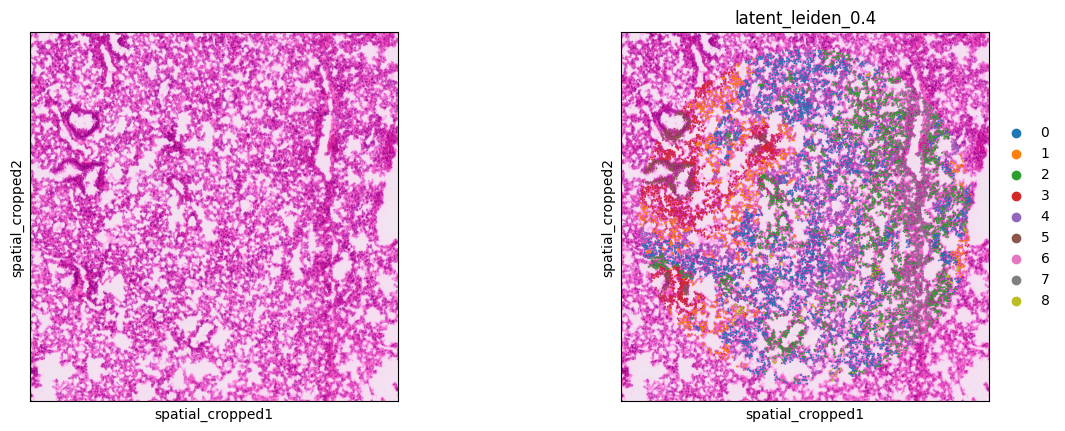

/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


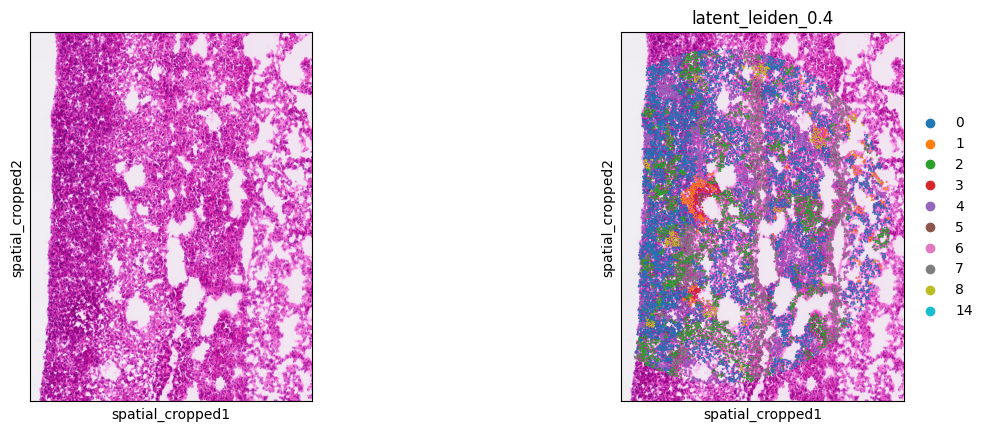

/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


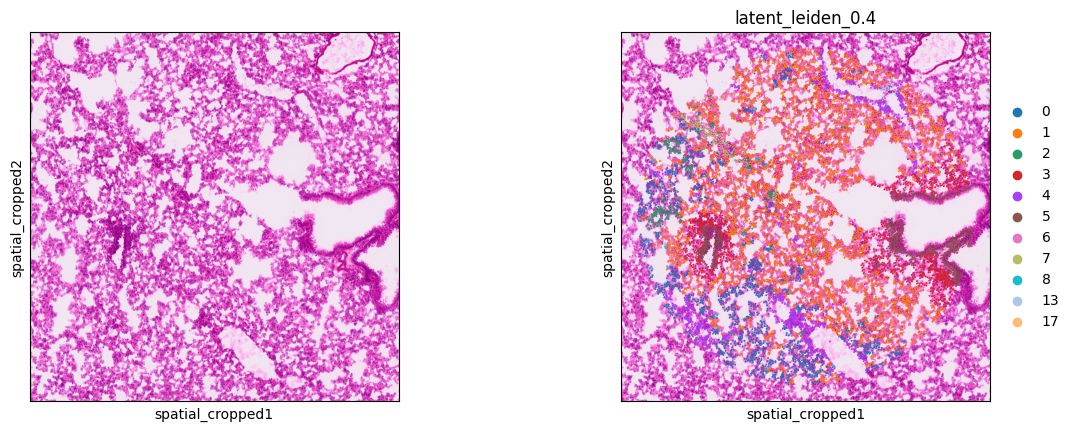

/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/scanpy/plotting/_utils.py:432: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


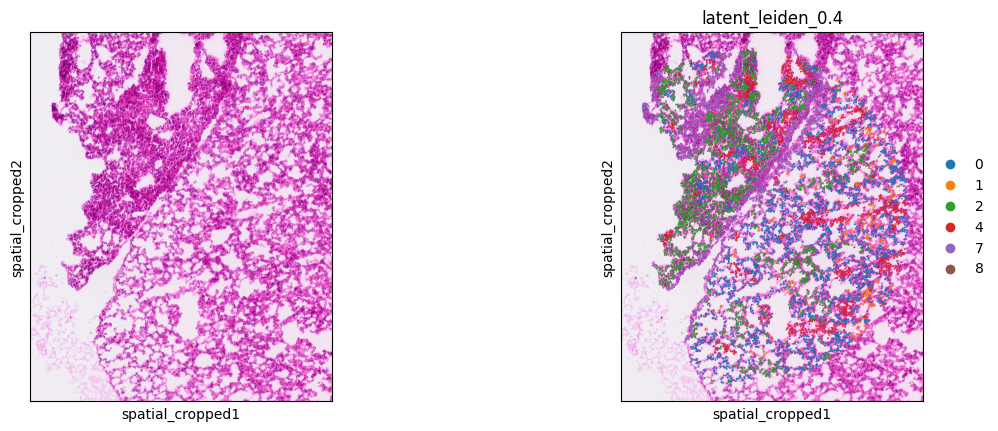

In [8]:
for spot in (tuple(row) for row in  adata.obsm["spatial"][np.random.choice(adata.n_obs, 4, replace=False)]):
    sc.pl.spatial(spatial_subset(adata, ["circle"], [(spot, 2500)], ["keep"]), color=[None, "latent_leiden_0.4"], img_key="0.25_mpp", basis="spatial_cropped", spot_size=25)

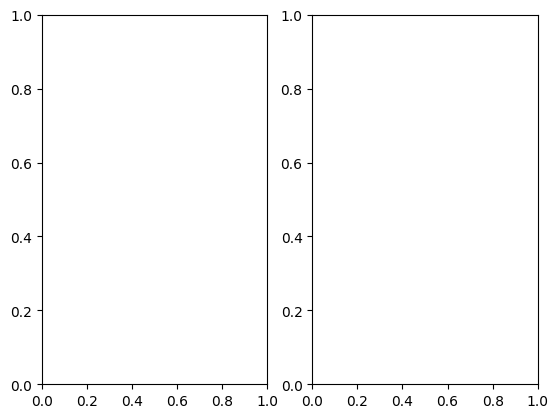

In [24]:
fig, axs = plt.subplots(1, 2)

/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


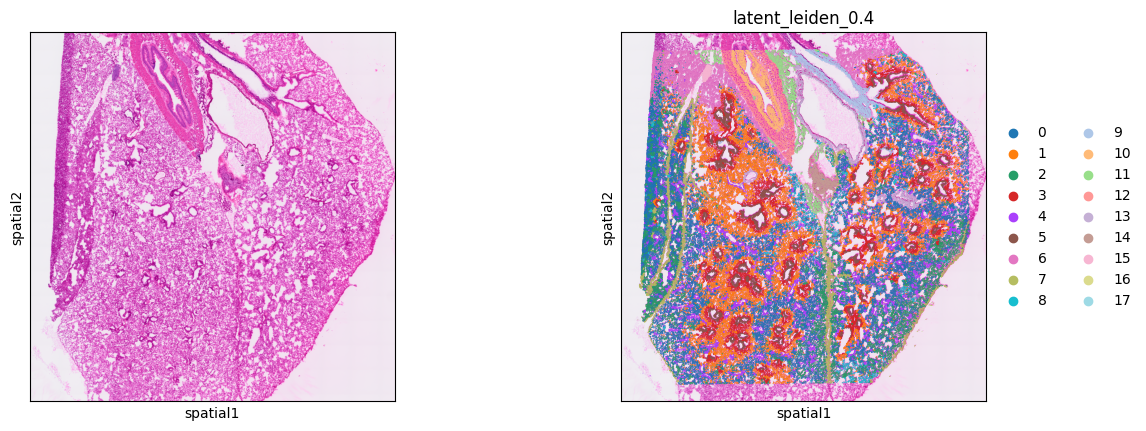

/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


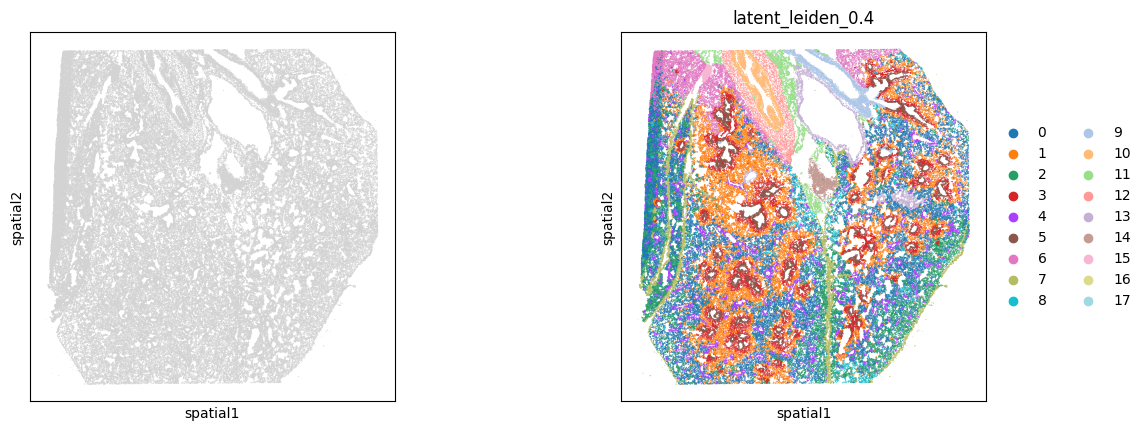

In [13]:
sc.pl.spatial(adata, color=[None, "latent_leiden_0.4"], spot_size=50)
sc.pl.spatial(adata, color=[None, "latent_leiden_0.4"], img_key=None, spot_size=50)

In [17]:
model.adata

AnnData object with n_obs × n_vars = 313497 × 1000
    obs: 'bin_count', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'nichecompass_active_gp_names', 'nichecompass_genes_idx', 'nichecompass_gp_names', 'nichecompass_latent', 'nichecompass_source_genes_idx', 'nichecompass_sources_categories_label_encoder', 'nichecompass_target_genes_idx', 'nichecompass_targets_categories_label_encoder', 'spatial', 'spatial_neighbors', 'umap'
    obsm: 'X_umap', 'nichecompass_latent', 'spatial', 'spatial_cropped'
    varm: 'nichecompass_gp_sources', 'nichecompass_gp_sources_categories', 'nichecompass_gp_targets', 'nichecompass_gp_targets_categories'
    obsp: 'nichecompass_latent_connectivities', 'nichecompass_latent_distances', 'spatial_connectivities', 'spatial_distances'

In [18]:
sc.pp.neighbors(adata)
adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 313497 × 17743
    obs: 'bin_count', 'array_row', 'array_col', 'latent_leiden_0.4'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'latent_leiden_0.4_colors', 'neighbors'
    obsm: 'spatial', 'spatial_cropped', 'X_pca'
    obsp: 'distances', 'connectivities'

In [23]:
sc.tl.leiden(
    adata,
    resolution=0.4,
    key_added="latent_leiden_0.4_pca",
    neighbors_key="neighbors"
)

/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ceger/miniforge3/envs/nichecompass_0_2_1-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


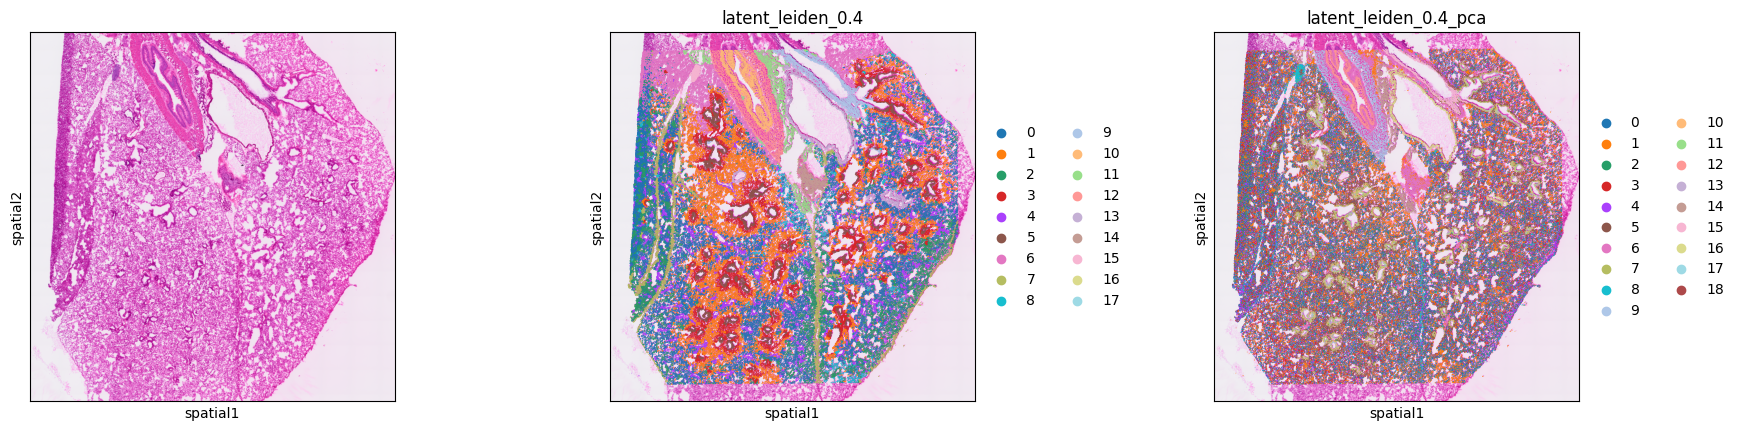

In [26]:
sc.pl.spatial(adata, color=[None, "latent_leiden_0.4", "latent_leiden_0.4_pca"], spot_size=50)


In [25]:
adata

AnnData object with n_obs × n_vars = 313497 × 17743
    obs: 'bin_count', 'array_row', 'array_col', 'latent_leiden_0.4', 'latent_leiden_0.4_pca'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'
    uns: 'spatial', 'latent_leiden_0.4_colors', 'neighbors', 'leiden'
    obsm: 'spatial', 'spatial_cropped', 'X_pca'
    obsp: 'distances', 'connectivities'

In [ ]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")